# 5. Velocity Comparison

## 5.1. Notebook setup

In [1]:
import os
import sys

import emcee
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import smplotlib

In [2]:
epochs = ["A", "B", "C", "D", "E", "F"]
data_path = "../data/"
fig_path = "../figures/"
calibrator = "J0340"
target = "HR1099"

cm = ['#377eb8', '#e41a1c', '#4daf4a', '#dede00', '#ff7f00', '#999999', '#984ea3', '#f781bf', '#a65628']
marker_cycle = ["o", "v", "X", "<", "D", "^"]

sys.path.append(os.path.join(os.getcwd(), ".."))
from library import HR1099_astrometry, utils

deg = np.pi / 180
mas = deg / (60 * 60 * 1000)

## 5.2. Import data

In [3]:
speed, quality = np.genfromtxt(data_path + "solar_cmes.txt", 
    skip_header=4, usecols=(4, 12), unpack=True, 
    delimiter=(11, 10, 7, 7, 7,8,7,7,10,10,10,7,46), autostrip=True, 
    encoding=None, dtype=None)
mask = np.array(['poor' not in v.lower() for v in quality] and ['----' not in v.lower() for v in speed])
speed = speed[mask]
speed = [float(v) for v in speed]
quality = quality[mask]

mean_jd = np.genfromtxt(
        data_path + target + "_I_positions.txt",
        skip_header=2,
        dtype="U5,f8,f8,f8,f8,f8,f8,f8",
        usecols=(5),
        unpack=True)
mean_mjd = np.round(mean_jd - 2400000.5, 1)

sampler = emcee.backends.HDFBackend(data_path + target + "_orbital_chain.h5")
flat_samples = sampler.get_chain(flat=True)
flat_samples = np.divide(flat_samples, np.array([1, 1, deg, deg]))

med_val = np.percentile(flat_samples, [16, 50, 84], axis=0)
lower_val = med_val[1] - med_val[0]
upper_val = med_val[2] - med_val[1]
med_val = med_val[1]

hr1099 = HR1099_astrometry.HR1099_astrometry(med_val[2] * deg, med_val[3] * deg)
T, P, d, a, m1, m2, R1, R2 = hr1099.hr1099_info()

## 5.3. Plot

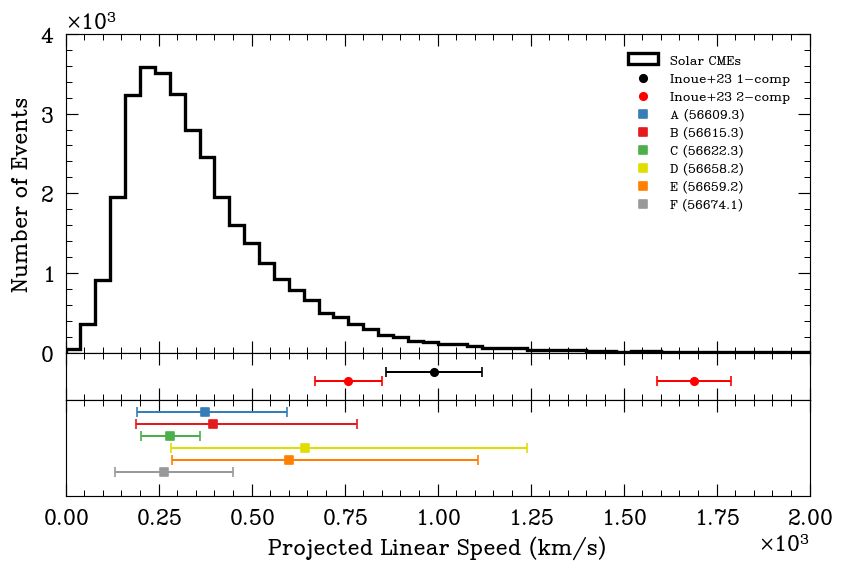

In [4]:
fig, ax = plt.subplots(3, 1, figsize=(8, 5), sharex=True, gridspec_kw={"height_ratios": [5, 0.75, 1.5]})
fig.subplots_adjust(hspace=0)

ls = []
n, bins, patches = ax[0].hist(speed, bins=50, color="black", range=(0, 2000), 
    histtype='step', label='Solar CMEs', linewidth=2)

ls.append(patches[0])

# Inoue 2023 H-alpha flares
l1 = ax[1].scatter([990], [0.2], marker="o", color="black", s=20, label="Inoue+23 1-comp")
ax[1].errorbar([990], [0.2], xerr=[[130], [130]], fmt='none', color="black", capsize=3)
l2 = ax[1].scatter([1690], [-0.2], marker="o", color="red", s=20, label="Inoue+23 2-comp")
ax[1].errorbar([1690], [-0.2], xerr=[[100], [100]], fmt='none', color="red", capsize=3)
ax[1].scatter([760], [-0.2], marker="o", color="red", s=20)
ax[1].errorbar([760], [-0.2], xerr=[[90], [90]], fmt='none', color="red", capsize=3)
ls.append(l1)
ls.append(l2)

for i, epoch in enumerate(epochs):
    sampler = emcee.backends.HDFBackend(data_path + epochs[i] + "_" + target + "_velocity_chain.h5")
    samples = sampler.get_chain(flat=True)
    samples[:, 0] = d * np.tan(samples[:, 0]*mas) / (24 * 60 * 60) / 1e3 # mas/day -> km/s
    samples[:, 2] = d * np.tan(samples[:, 2]*mas) / (24 * 60 * 60) / 1e3 # mas/day -> km/s

    epoch_speed = np.sqrt(samples[:, 0]**2 + samples[:, 2]**2)
    lower, mid, upper = np.percentile(epoch_speed, [16, 50, 84])

    ln = ax[2].scatter([mid], [-(i-3)/4], marker="s", color=cm[i], s=20, label="%s (%.1f)" % (epoch, mean_mjd[i]))
    ax[2].errorbar([mid], [-(i-3)/4], xerr=[[mid-lower], [upper-mid]], fmt='none', color=cm[i], capsize=3)
    ls.append(ln)

ax[2].set_xlabel("Projected Linear Speed (km/s)")
ax[0].set_ylabel("Number of Events")
ax[0].set_xlim(0, 2000)
ax[0].set_ylim(0, 4000)
ax[1].set_ylim(-1, 1)
ax[2].set_ylim(-1, 1)
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[0].legend(ls, [l.get_label() for l in ls], loc="upper right", fontsize=9)
plt.savefig(fig_path + "velocity_comparison.pdf", bbox_inches="tight")
plt.show()